Download a Modis Aqua scene from http://modis.gsfc.nasa.gov/data/dataprod/

In [1]:
site.addsitedir("/Users/berringtonaca/repos/A212")
from a212utils.download import download_file
from IPython.display import Image
import h5py
import pandas as pd

download = False
if download:
    #
    #  satelite data for day 127 of 2014  Modis Aqua level 3 cloud data
    #
    url = 'http://clouds.eos.ubc.ca/~phil/Downloads/a212/fields.h5'
    local_file = download_file(url)
    print('downloaded {}'.format(local_file))
else:
    local_file='fields.h5'

In [2]:
%matplotlib inline
from pathlib import Path
import a212data
picwidth = 800
datadir = a212data.__path__[0]
image_path = Path(datadir).joinpath('MYBRGB.A2014127.2110.005.2014128174940.jpg')
print(str(image_path))
Image(str(image_path),width=picwidth)

/Users/berringtonaca/repos/A212/notebooks/a212data/MYBRGB.A2014127.2110.005.2014128174940.jpg


Use [h5py](http://docs.h5py.org/en/latest/)   to read the image data

In [3]:
from a212utils.h5dump import dumph5
if download:
    dumph5(local_file)

In [4]:
with h5py.File(local_file,'r') as f:
    file_dict = {}
    vars = ['ch29','ch31','cloud_mask','phase']
    for name in vars:
        fullname = '/A2014127/{}'.format(name)
        file_dict[name] = f[fullname][...]
    file_dict.update(f.attrs.items())

In [5]:
file_dict.keys()

dict_keys(['phase_vals', 'phase', 'mask_vals', 'ch29', 'cloud_mask', 'ch31'])

In [6]:
#
# make a 5 color palette
#
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap 
colors = ["royal blue", "baby blue", "eggshell", "burnt red", "soft pink"]
print([the_color for the_color in colors])
colors=[sns.xkcd_rgb[the_color] for the_color in colors]
pal=ListedColormap(colors,N=5)

['royal blue', 'baby blue', 'eggshell', 'burnt red', 'soft pink']


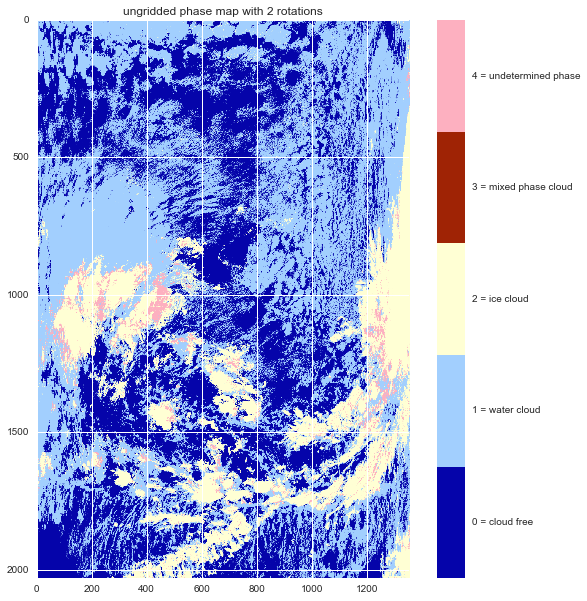

In [7]:
# #
# the A2014127.2110 scene is a descending orbit, so south is on top
# and west is on the right, need to rotate through 180 degrees
#
%matplotlib inline
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,1,figsize = (10,10))
phase_rot=np.rot90(file_dict['phase'],2)
CS=ax.imshow(phase_rot,cmap=pal)
ax.set_title('ungridded phase map with 2 rotations')
cax=fig.colorbar(CS)
#
# we wrote the phase legend into the h5 attributes
# use it to label the color axis
#
labels=file_dict['phase_vals']
labels=labels.split(',')
ends=np.linspace(0,4,6)
centers=(ends[1:] + ends[:-1])/2.
cax.set_ticks(centers)
cax.set_ticklabels(labels)

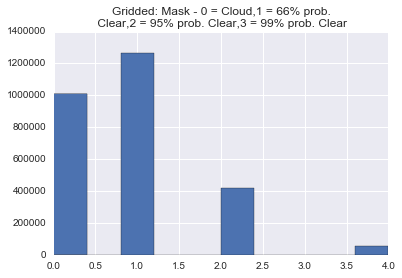

In [8]:
plt.close('all')
fig,ax=plt.subplots(1,1)
ax.hist(phase_rot.ravel())
ax.set_title('Gridded: Mask - 0 = Cloud,1 = 66% prob.\n Clear,2 = 95% prob. Clear,3 = 99% prob. Clear')

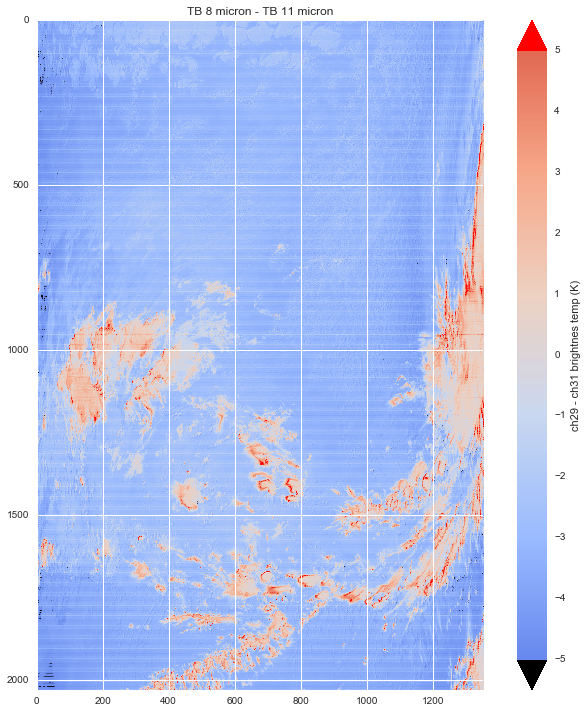

In [9]:
plt.close('all')
from matplotlib.colors import Normalize
from numpy import ma
fig,ax=plt.subplots(1,1,figsize=(12,12))
colors=sns.color_palette('coolwarm')
pal=LinearSegmentedColormap.from_list('test',colors)
pal.set_bad('0.75') #75% grey
pal.set_over('r')
pal.set_under('k')
vmin= -5.
vmax= 5.
ch29 = np.rot90(file_dict['ch29'],2)
ch31 = np.rot90(file_dict['ch31'],2)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
tdiff= ch29 - ch31
tdiff=ma.array(tdiff,mask=np.isnan(tdiff))
CS= ax.imshow(tdiff,cmap=pal,norm=the_norm)
cax=plt.colorbar(CS,  ax = ax,extend='both')
cax.set_label('ch29 - ch31 brightnes temp (K)')
ax.set_title('TB 8 micron - TB 11 micron')




### For next Tuesday: check in a notebook that

1. Create a pandas Dataframe with 3 columns:  phase, ch29, ch31 using rows
   1100:1500 of the rotated image
   
2. Use groupby on the phase column to collect pixels with the same phase

3. Loop through each of the phases and calculate the mean ch29 and ch 31 values
   for that phase and the mean of the differences.
   
4. Write those results out as a new DataFrame with 5 columns (1 for each phase)
   and 1 row

In [10]:
the_slice=slice(1100,1500)
column_data = dict(phase=phase_rot[the_slice,:].ravel(),ch29=ch29[the_slice,:].ravel(),ch31=ch31[the_slice,:].ravel())

In [11]:
df_satellite = pd.DataFrame(column_data)

In [12]:
groups=df_satellite.groupby('phase')

In [13]:
data_frames=[]
chan_dict={}
for value in ['ch29','ch31']:
    chan_dict[value] = {}  
    for phase, group in groups:
        #save the mean for each phase
        chan_dict[value][phase] = group[value].mean()
df_dict={}
for value in ['ch29','ch31']:
    temps=list(chan_dict[value].values())
    names = list(chan_dict[value].keys())
    df_dict[value] = pd.DataFrame.from_records([temps],columns=names)
df_dict['Tdiff'] = df_dict['ch31'] - df_dict['ch29']

In [14]:
df_dict['Tdiff']

,0,1,2,4
0,2.753448,2.61026,-0.594452,0.821838


### For next week

Check in a notebook that:

1) breaks the image into 16 subsets (4 x 4 in rows and columns)

2) write a function that produces a two new data frames for the the ch31 and  ch31 - ch29 mean temperature
   that have a column for each phase and 16 rows, one for each subset.
   
3) Make a scatterplot with 4 symbols (one for each phase) that plots ch31 on the x axis and ch31 - ch29 on the y axis

In [18]:
print(np.shape(phase_rot))

yslice = slice(0,2028)
xslice = slice(0,1352)
new_dict = dict(phase=phase_rot[yslice,xslice],ch29=ch29[yslice,xslice],ch31=ch31[yslice,xslice])
yspace = np.arange(0,2028,507)
xspace = np.arange(0,1352,338)

print(yspace)
print(xspace)

# To store each key from the dictionary into 4x4 arrays

storephase = []
for leftrow in yspace:
    for leftcol in xspace:
        storephase.append((new_dict['phase'])[leftrow:leftrow+507,leftcol:leftcol+338])
        
storech29 = []
for leftrow in yspace:
    for leftcol in xspace:
        storech29.append((new_dict['ch29'])[leftrow:leftrow+507,leftcol:leftcol+338])
        
storech31 = []
for leftrow in yspace:
    for leftcol in xspace:
        storech31.append((new_dict['ch31'])[leftrow:leftrow+507,leftcol:leftcol+338])

def gendict(phasearray,ch29array,ch31array):
    '''Function to generate the ch31 and ch31-ch29 mean temp dictionaries
    inputs: phase (list of np.ndarrays), ch29 (list of np.ndarrays), ch31 (list of np.ndarrays)
    outputs: meandict (pd.dict)'''
       
    #ch31df = pd.DataFrame(columns=4)
    #tempdiffdf = pd.DataFrame(columns=4)
    
    for i in range(0,16):
        inds0 = np.where(phasearray[i] == 0)
        inds1 = np.where(phasearray[i] == 1)
        inds2 = np.where(phasearray[i] == 2)
        inds4 = np.where(phasearray[i] == 4)
        
        temps31_mean0 = np.mean(ch31array[i][inds0])
        temps31_mean1 = np.mean(ch31array[i][inds1])
        temps31_mean2 = np.mean(ch31array[i][inds2])
        temps31_mean4 = np.mean(ch31array[i][inds4])
        
        tempdiff_mean0 = np.mean(ch31array[i][inds0]-ch29array[i][inds0])
        tempdiff_mean1 = np.mean(ch31array[i][inds1]-ch29array[i][inds1])
        tempdiff_mean2 = np.mean(ch31array[i][inds2]-ch29array[i][inds2])
        tempdiff_mean4 = np.mean(ch31array[i][inds4]-ch29array[i][inds4])

    df = pd.DataFrame([temps31_mean0, temps31_mean1, temps31_mean2, temps31_mean4], columns=list('0124'))
    df2 = pd.DataFrame([tempdiff_mean0, tempdiff_mean1, tempdiff_mean2, tempdiff_mean4], columns=list('0124'))
    return df,df2

print(gendict(storephase,storech29,storech31))


(2030, 1354)
[   0  507 1014 1521]
[   0  338  676 1014]


/Applications/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


ValueError: Shape of passed values is (1, 4), indices imply (4, 4)

In [ ]:
temps31 = storech31[0][inds0]
print(np.shape(temps31))
temps29 = storech29[0][inds0]
print(np.shape(temps29))